# VisClaw.jl - examples with GMT.jl

<div style="text-align: right;"> VisClaw.jl v0.7.2 </div>
<div style="text-align: right;"> Clawpack v5.7.1 </div>
<div style="text-align: right;"> Takuya Miyashita (miyashita@hydrocoast.jp) </div>

## Load conditions and numerical results 
This process is the same as [Examples using Plots.jl](https://github.com/hydrocoast/visclaw_julia/blob/master/Example_using_Plots.ipynb).

In [1]:
using VisClaw
using GMT: GMT
using Printf

simdir = joinpath(CLAW, "geoclaw/examples/tsunami/chile2010/_output")
topo = loadtopo(simdir)

# check
println(typeof(topo))
println(fieldnames(typeof(topo)))

VisClaw.Topo
(:ncols, :nrows, :x, :y, :dx, :dy, :elevation)


## Plot using GMT
### Plot topo

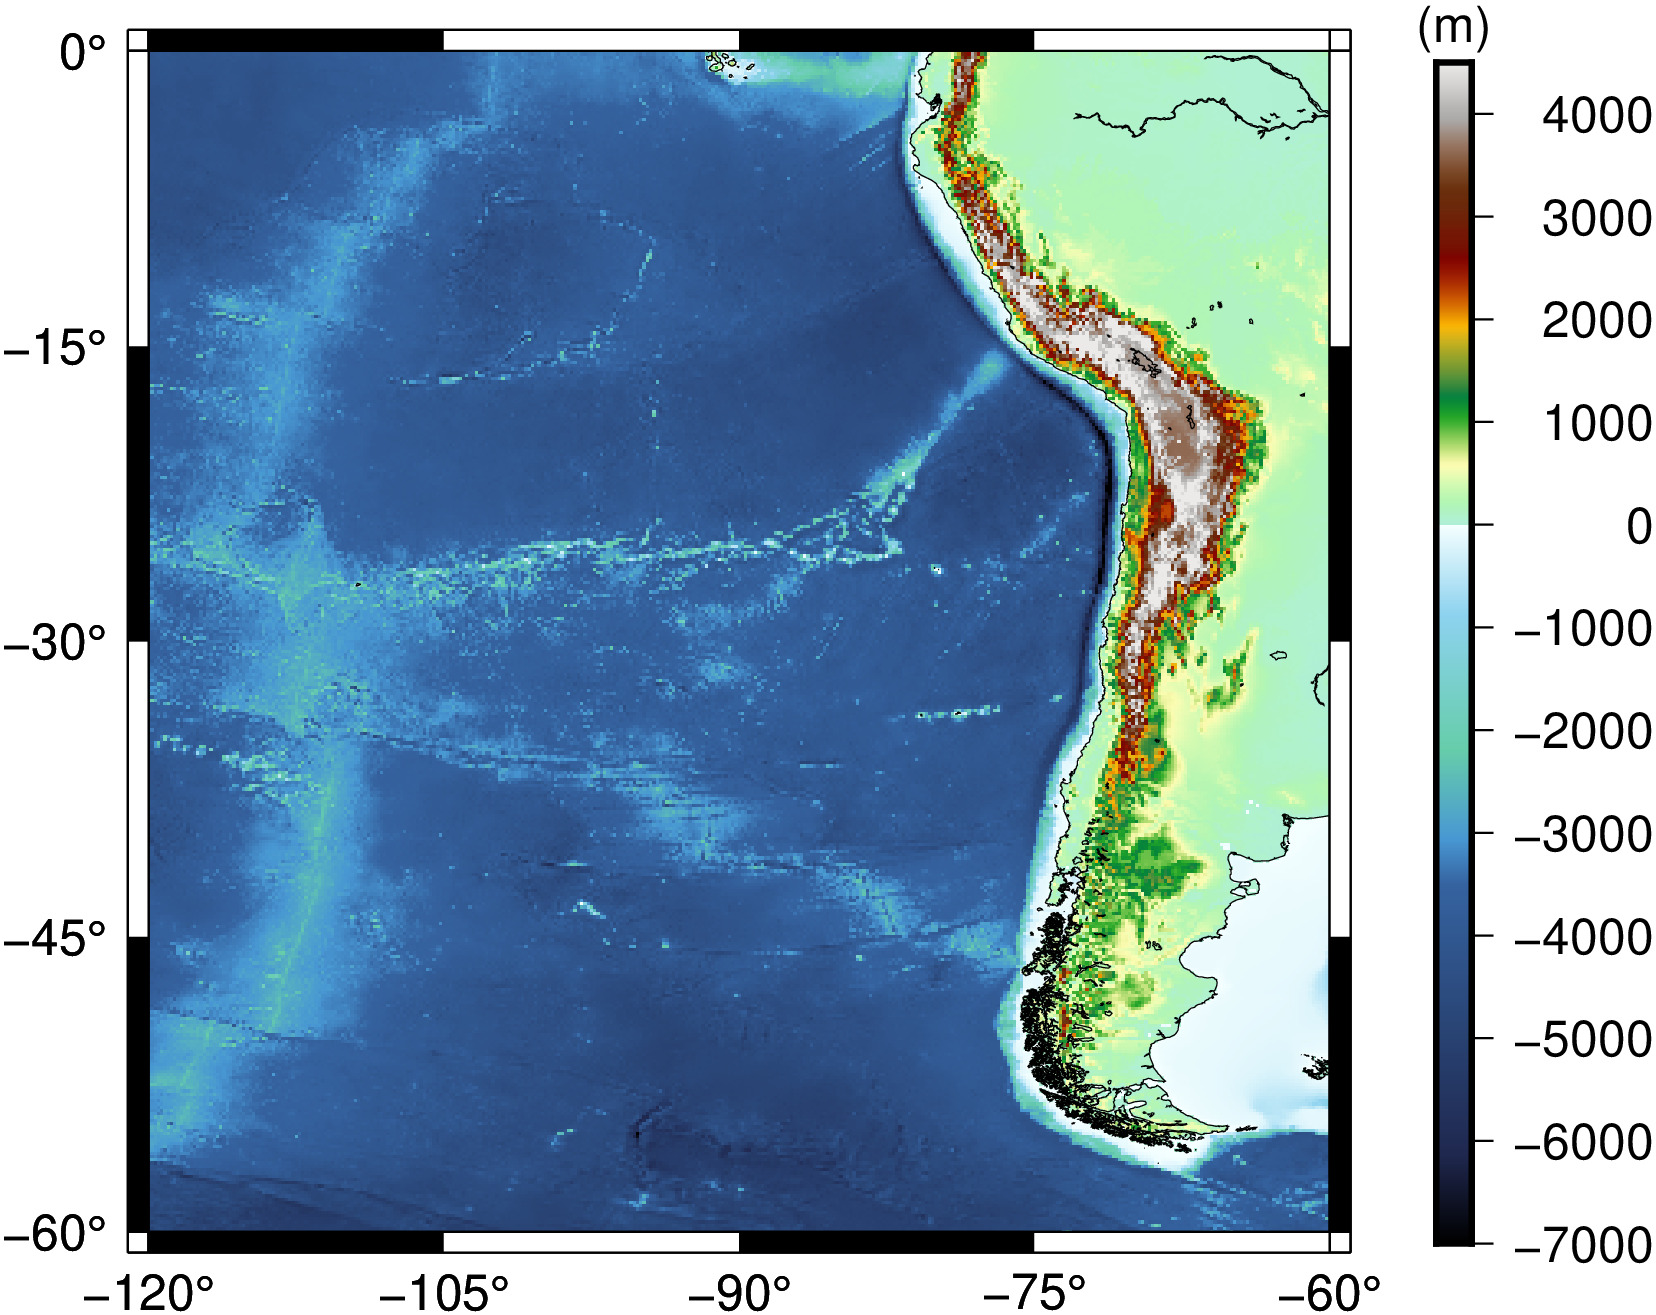

In [2]:
# makegrd
G = geogrd(topo)

# makecpt
cpt = GMT.makecpt(; C=:earth, T="-7000/4500", D=true)

# plot
GMT.grdimage(G, C=cpt, J="X10d", R=G, Q=true)
GMT.colorbar!(J="X10d", R=G, B="xa1000f1000 y+l\"(m)\"", D="jBR+w10.0/0.3+o-1.2/-0.1")
GMT.coast!(J="X10d", R=G, B="a15f15 neSW", D=:i, W=:thinnest, fmt="png", show=true)

### Plot dtopo

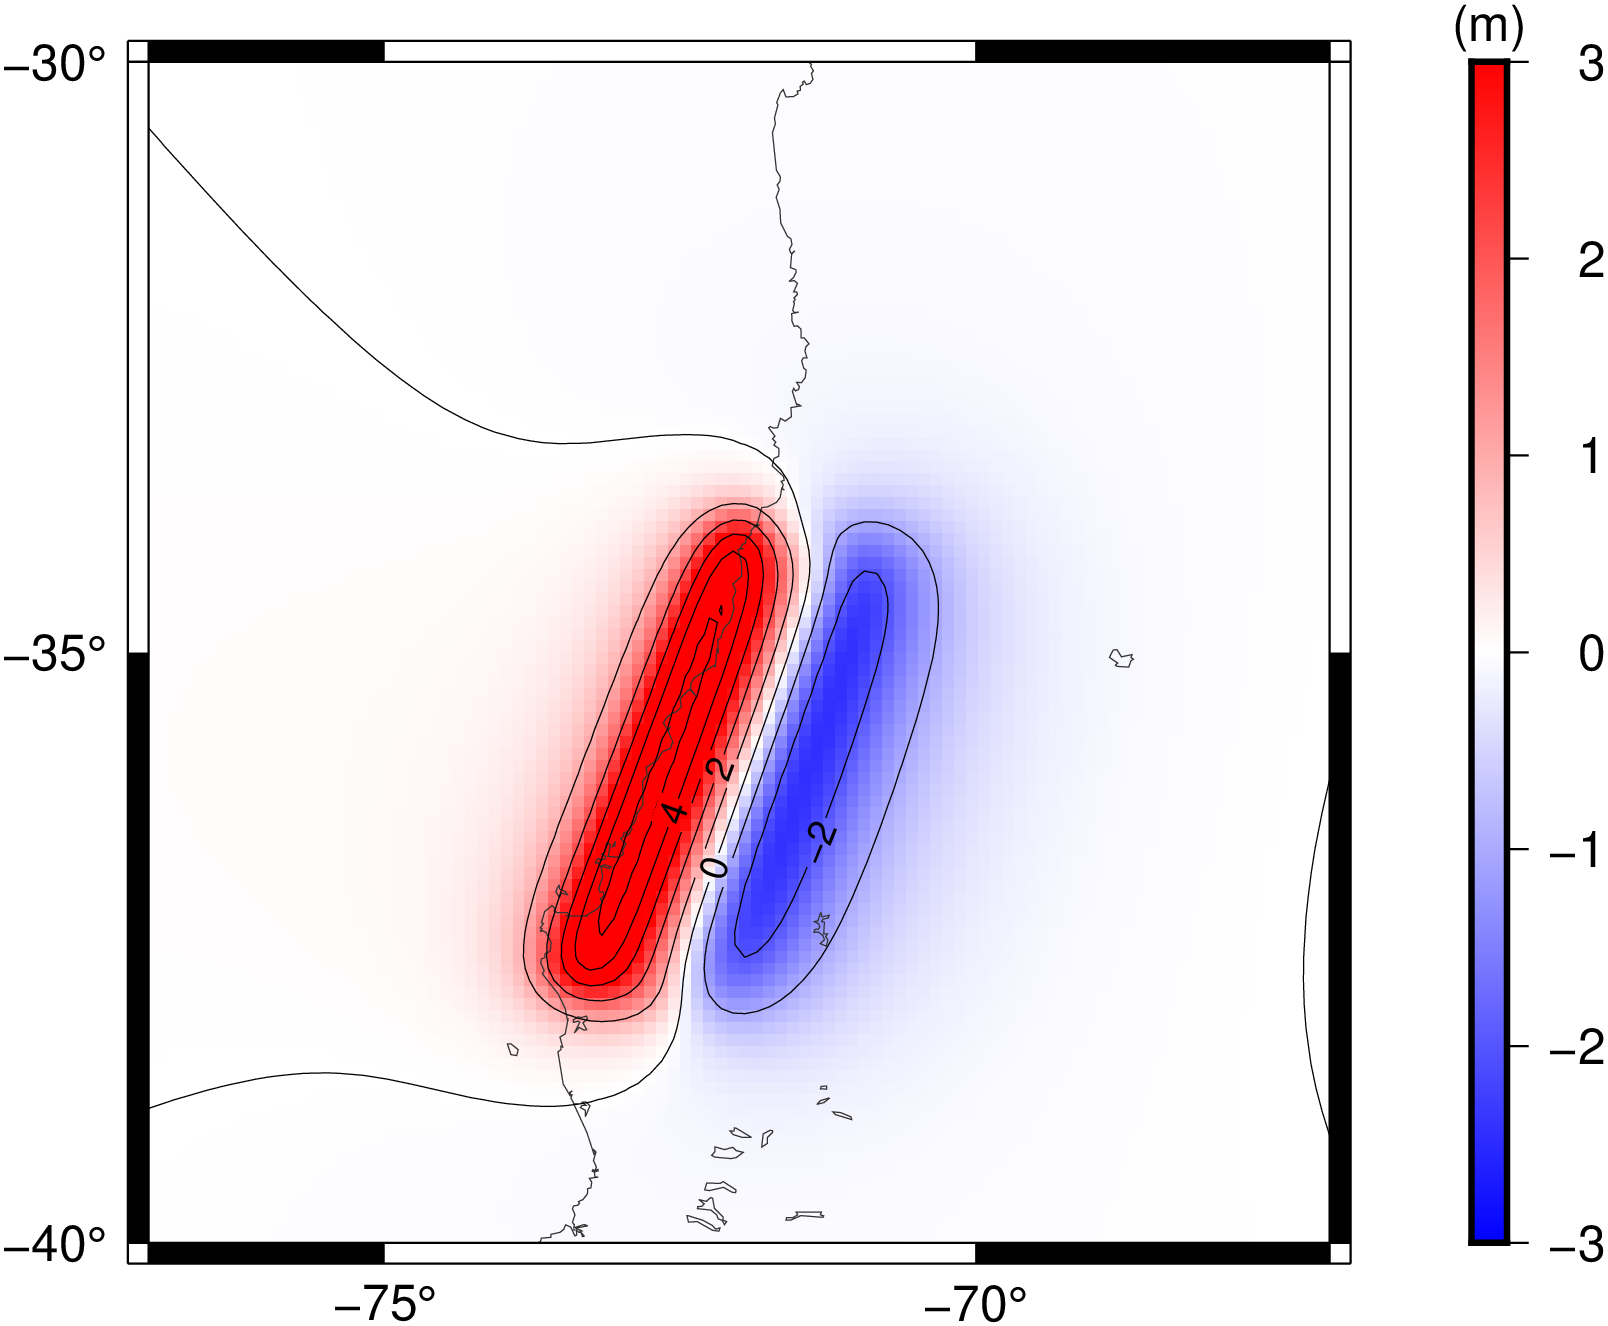

In [3]:
# dtopo
dtopo = loaddtopo(simdir)
# makegrd
G = geogrd(dtopo)

# makecpt
cpt = GMT.makecpt(; C=:polar, T="-3.0/3.0", D=true)

# plot
GMT.grdimage(G, C=cpt, J="X10d", R=G, B="", Q=true)
GMT.colorbar!(C=cpt, J="X10d", R=G, B="xa1.0f1.0 y+l\"(m)\"", D="jBR+w10.0/0.3+o-1.5/0.0")
GMT.coast!(J="X10d", R=G, D=:i, W="thinnest,gray20")
GMT.grdcontour!(G, J="X10d", R=G, B="a5f5 neSW", C=1, A=2, W=:black, fmt="png", show=true)

### Plot sea surface height

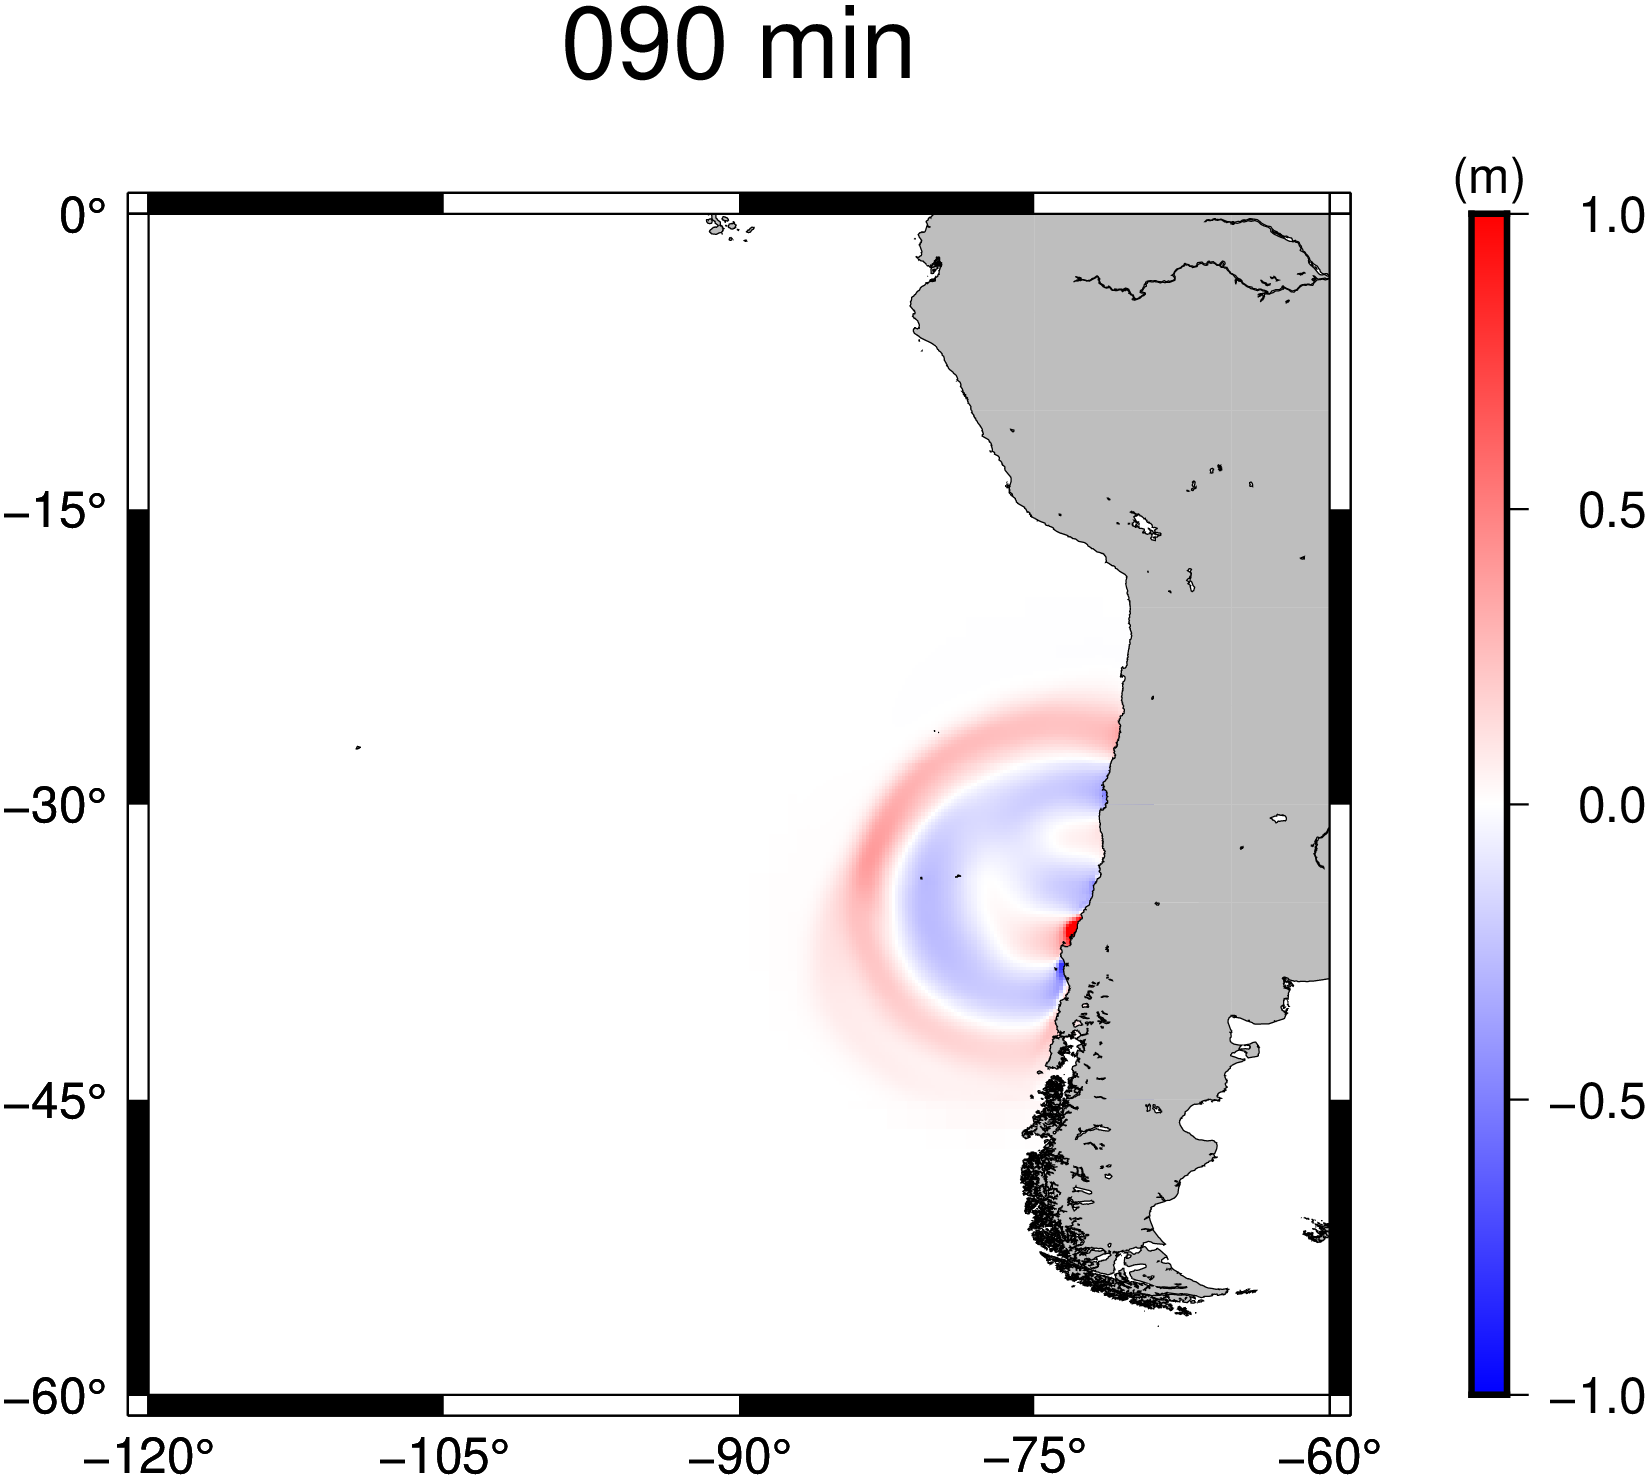

In [4]:
# load water surface height
amrall = loadsurface(simdir, 1:5) # fort.q0000 to fort.q0004
coarsegridmask!(amrall)
replaceunit!(amrall, :minute)

# commom options: projection J and region R
region = getR(amrall.amr[1])
proj = getJ("X10d", axesratio(amrall.amr[1]))

# makecpt
cpt = GMT.makecpt(C=:polar, T="-1.0/1.0", D=true)

# snapshot: index 4
i = 4

    # step
    time_str = @sprintf("%03d", amrall.timelap[i])*" min"

    # land-masked surface grids
    G = tilegrd(amrall, i; length_unit="d")

    # plot
    GMT.basemap(J=proj, R=region, title=time_str)
    GMT.grdimage!.(G, C=cpt, J=proj, R=region, B="", Q=true)
    GMT.colorbar!(C=cpt, J=proj, R=region, B="xa0.5f0.5 y+l(m)", D="jBR+w10.0/0.3+o-1.5/0.0")
    GMT.coast!(J=proj, R=region, B="a15f15 neSW", D=:i, W=:thinnest, G=:gray, fmt="png", show=true)

### Plot pressure and wind fields

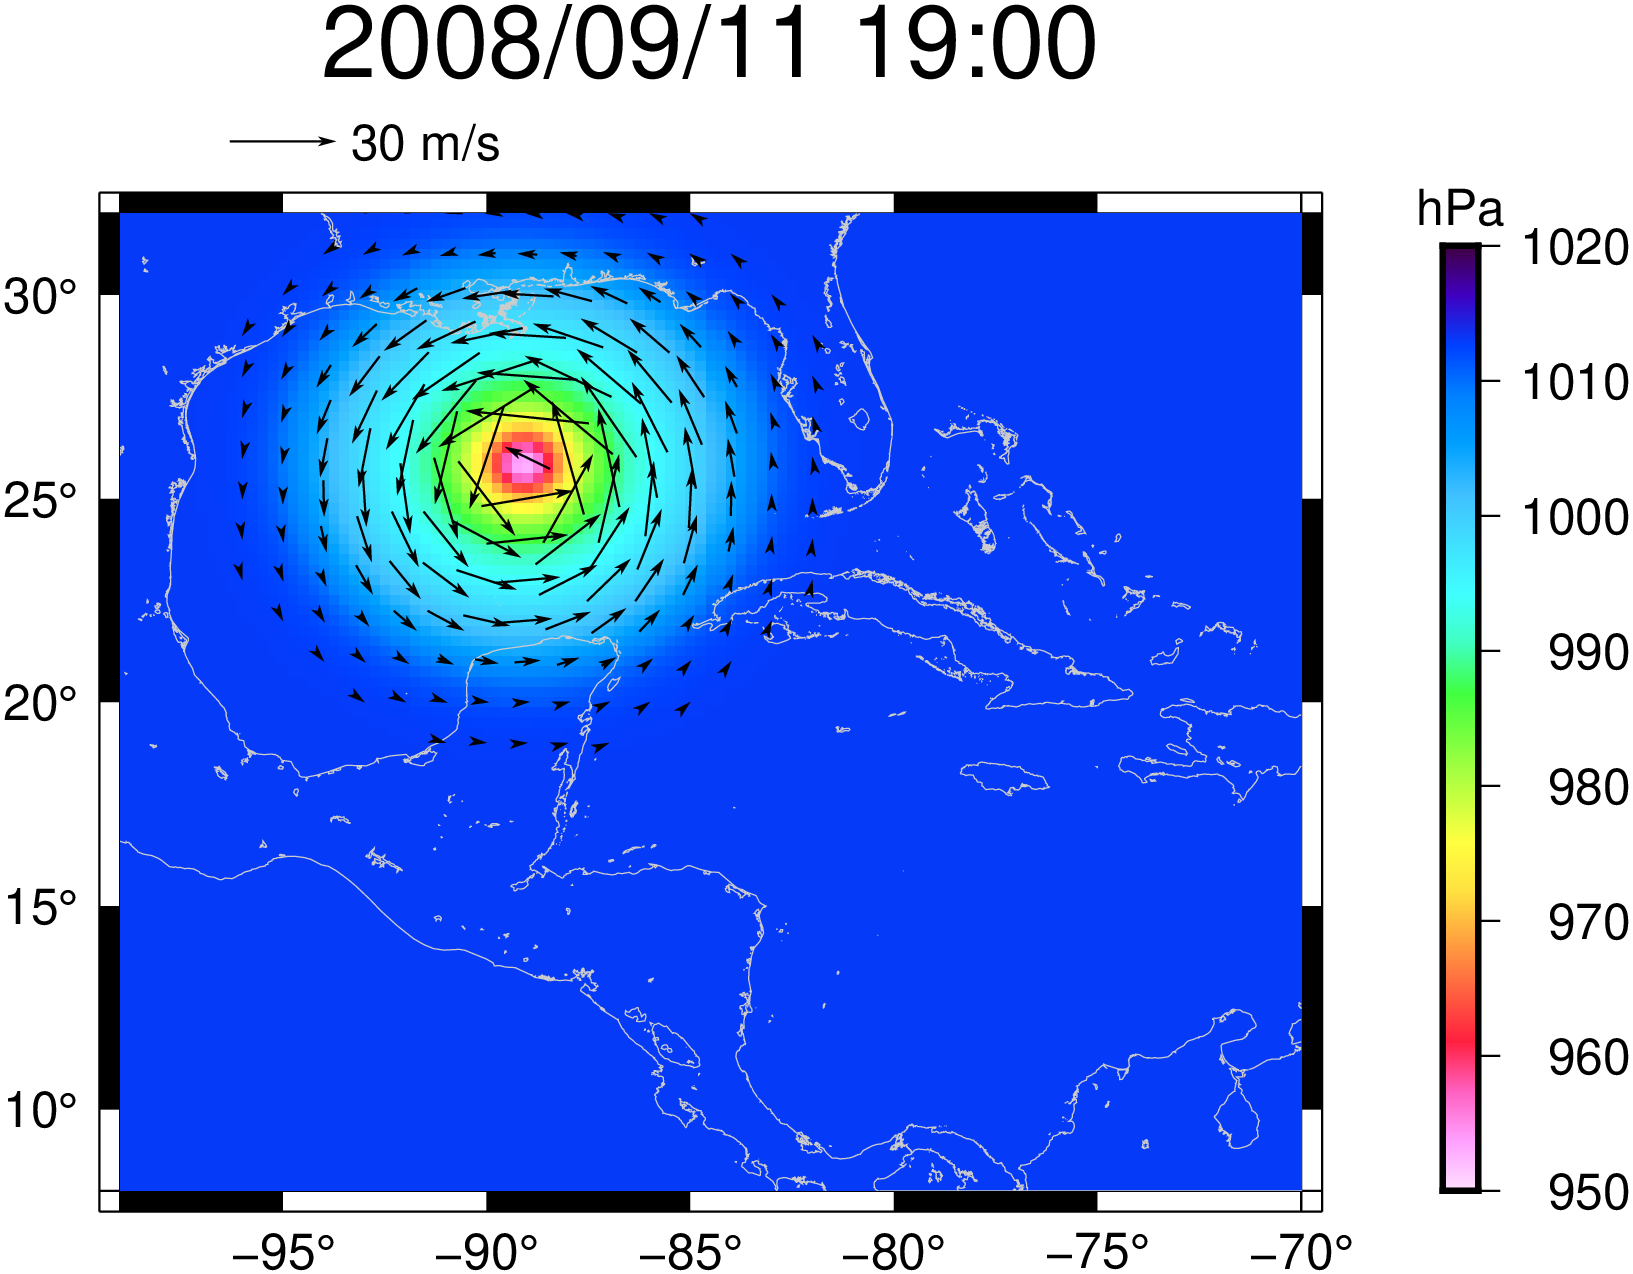

surface [WARNING]: Input data lie exactly on a plane.
surface [WARNING]: Input data lie exactly on a plane.
surface [WARNING]: Input data lie exactly on a plane.


In [5]:
using Dates: Dates
timeorigin = Dates.DateTime(2008, 9, 13, 7)

simdir = joinpath(CLAW,"geoclaw/examples/storm-surge/ike/_output")
truncvel = 5.0e-1
arrowscale = [-95,30,30,0] # x, y, u, v
Gus, Gvs = arrowscalegrd(arrowscale...)

## load
amrall = loadstorm(simdir; AMRlevel=1)
coarsegridmask!(amrall)

## timelap
time_dates = @. timeorigin + Dates.Millisecond(1e3*amrall.timelap)
time_str = Dates.format.(time_dates, "yyyy/mm/dd HH:MM")

## make cpt
cpt = GMT.makecpt(C=:wysiwyg, T="950/1020", D=true, I=true)

## projection
proj = getJ("X10d", amrall.amr[1])
region = getR(amrall.amr[1])

# snapshot: index 7
i = 7
    outpng = "ike_storm-"*@sprintf("%03d", i)*".png"

    Gp = tilegrd(amrall, i; length_unit="d")
    Gu, Gv = arrowgrd(amrall, i)

    GMT.psbasemap(J=proj, R=region, B="a5f5 neSW", title=time_str[i])
    map(G -> GMT.grdimage!(G, J=proj, R=region, C=cpt), Gp)
    GMT.colorbar!(B="xa10f10 y+lhPa", D="jBR+w8.0/0.3+o-1.5/0.0")
    GMT.coast!(D=:i, W="thinnest,gray80")
    GMT.grdvector!(Gu, Gv, I=[1,1], J=proj, R=region, lw=0.5, fill=:black, S="i0.03", arrow=(len=0.15, stop=:arrow, shape=0.5, fill=:black, justify=:center))
    GMT.grdvector!(Gus, Gvs, J=proj, R=region, lw=0.5, fill=:black, S="i0.03", arrow=(len=0.15, stop=:arrow, shape=0.5, fill=:black, justify=:center), Y=1.3)
    GMT.pstext!(GMT.text_record([arrowscale[1]+3.5 arrowscale[2]], @sprintf("%0.0f", sqrt(arrowscale[3]^2+arrowscale[4]^2))*" m/s"), R=region, fmt="png", show=true)